In [43]:
import ee
import geemap
geemap.ee_initialize()

In [44]:
m = geemap.Map()
states = ee.FeatureCollection("TIGER/2018/States")
fc = states.filter(ee.Filter.eq("NAME", "Alaska"))
m.add_layer(fc, {}, "Alaska")
m.center_object(fc, 4)
geemap.ee_to_csv(fc, filename="Alaska.csv")

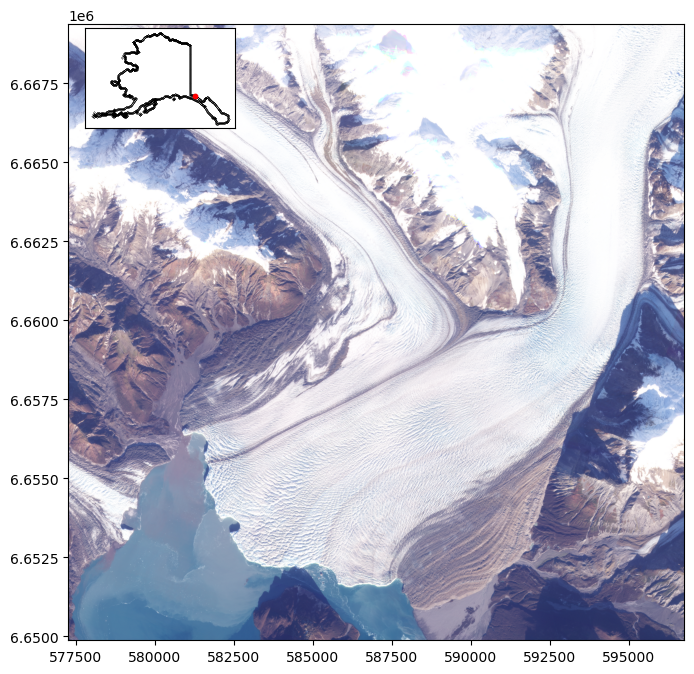

In [36]:
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.enums import Resampling
from pyproj import Transformer
from rasterio.windows import Window
import pandas as pd
from pyproj import Proj, transform

def pct_clip(array,pct=[2,98]):
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0
    return clip

with rio.open('Planet_Hubbard.tif') as src:
    with rio.open(
            'RGB_Temp.tif', 'w+',
            driver='GTiff',
            dtype= rio.float32,
            count=3,
            crs = src.crs,
            width=src.width,
            height=src.height,
            transform=src.transform,
        ) as dst:
        V = pct_clip(src.read(1))
        dst.write(V,1)
        V = pct_clip(src.read(2))
        dst.write(V,2)
        V = pct_clip(src.read(3))
        dst.write(V,3)
        
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

window = rio.windows.Window(3000, 3000, 6500, 6500)
with rio.open("RGB_Temp.tif") as src2:
    data = src2.read(window=window)
    transform = rio.windows.transform(window, src2.transform)
    show(data, transform=transform, ax=ax)

# this is for flowline, need to load csv for points
#transformer = Transformer.from_crs("epsg:3413", "epsg:32607") # UTM 6N
#x, y = transformer.transform(points.X.to_numpy(),points.Y.to_numpy())
#ax.plot(x,y,'r')


# add scale bar 

# add inset map 

# Read the CSV file into a DataFrame
df = pd.read_csv('Alaska_chain.csv')

# Split the coordinates into latitude and longitude
#df[['Longitude', 'Latitude', 'Value', 'Other']] = df[0].str.split(',', expand=True)
df['Longitude'] = df['X'].astype(float)
df['Latitude'] = df['Y'].astype(float)

# Filter out rows with negative longitudes
#df = df[df['Longitude'] <= 0]
# Filter out values that are positive and less than -178
df = df[(df['Longitude'] > -168) & (df['Longitude'] <= 0)]

# Define the input projection (latitude and longitude) and the output projection (EPSG 3413)
transformer = Transformer.from_crs('epsg:4326', 'epsg:32607')

# Convert latitude and longitude coordinates to the EPSG 3413 projection
df['x'], df['y'] = transformer.transform(df['Latitude'].values, df['Longitude'].values)

# Add a subplot with a black background
ax_map = fig.add_axes([0.27, 0.75, 0.125, 0.125], facecolor='white')

# Plot the coordinates within the black box
ax_map.scatter(df['x'], df['y'], c='black', alpha=1, label='Coordinates', s=0.0005) 
ax_map.scatter([590839], [6657969], c='red', s=10)  
#ax_map.axis('off')
# Turn off the ticks and axis labels
ax_map.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
ax_map.set_xticks([])
ax_map.set_yticks([])
plt.show()
#plt.savefig('map_inset.png')

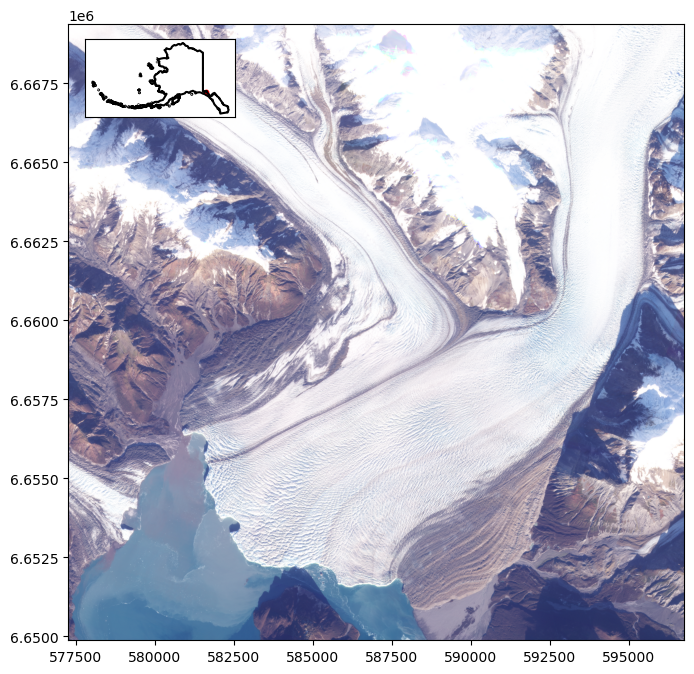

In [43]:
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.enums import Resampling
from pyproj import Transformer
from rasterio.windows import Window
import pandas as pd
from pyproj import Proj, transform
import geopandas as gpd

def pct_clip(array,pct=[2,98]):
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0
    return clip

with rio.open('Planet_Hubbard.tif') as src:
    with rio.open(
            'RGB_Temp.tif', 'w+',
            driver='GTiff',
            dtype= rio.float32,
            count=3,
            crs = src.crs,
            width=src.width,
            height=src.height,
            transform=src.transform,
        ) as dst:
        V = pct_clip(src.read(1))
        dst.write(V,1)
        V = pct_clip(src.read(2))
        dst.write(V,2)
        V = pct_clip(src.read(3))
        dst.write(V,3)
        
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

window = rio.windows.Window(3000, 3000, 6500, 6500)
with rio.open("RGB_Temp.tif") as src2:
    data = src2.read(window=window)
    transform = rio.windows.transform(window, src2.transform)
    show(data, transform=transform, ax=ax)

# this is for flowline, need to load csv for points
#transformer = Transformer.from_crs("epsg:3413", "epsg:32607") # UTM 6N
#x, y = transformer.transform(points.X.to_numpy(),points.Y.to_numpy())
#ax.plot(x,y,'r')

# add scale bar 

# add inset map 

# Read the CSV file into a DataFrame
df = gpd.read_file('Alaska_outline.shp')
#df = df.to_crs(epsg=32607)
minx, miny, maxx, maxy = -164, 50, -145, 68
#bbox = box(minx, miny, maxx, maxy)
# Crop the shapefile to the bounding box
cropped_df = df.cx[minx:maxx, miny:maxy]
df = df.to_crs(epsg=32607)
# Add a subplot with a black background
ax_map = fig.add_axes([0.27, 0.75, 0.125, 0.125], facecolor='white')

# Plot the coordinates within the black box
# Plot the shapefile on the map subplot
df.plot(ax=ax_map, color='black')
ax_map.scatter([590839], [6657969], alpha=1, c='red', s=10)  
#ax_map.axis('off')
# Turn off the ticks and axis labels
ax_map.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
ax_map.set_xticks([])
ax_map.set_yticks([])
plt.show()
#plt.savefig('map_inset.png')